# ST4240 - Data Mining - Assignment 1
## Group 40 - Aditya Kelvianto Sidharta

# Question 1

In [1]:
%matplotlib inline

import math
import datetime
import matplotlib.pyplot as plt
import operator
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_summary import DataFrameSummary
from isoweek import Week
from tqdm import tqdm
pd.options.display.max_columns = 50
import seaborn as sns
from sklearn.externals import joblib

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

Rossmann is a chain in 7 European countries with more than 3000 drug stores available. The store sales in each individual store is influenced by a lot of factors, most notably the ongoing sales/promotion, holidays, presence of other drug stores, location, and time. 

The task for this assigment is to build a statistical model to predict the daily "Sales" volume for the future 6 weeks for 1115 stores located in Germany. 

## Data Preparation

Firstly, I will load the train and test dataset. The store dataset contains all the information needed about each individual Store is stored in "Store" dataset. therefore, I will merge the store dataset so that I have more features about the stores that I can leverage on in building a more accurate predictive model. This features includes information about Competitor, Holiday, and Promos. I will use the Store ID to merge the stores dataset and train/test dataset

In [3]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_stores = pd.read_csv('store.csv')

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_test.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [7]:
df_train.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [9]:
df_stores.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

In [10]:
df_train = df_train.merge(df_stores, on='Store')
df_test = df_test.merge(df_stores, on='Store')

In [4]:
df_train.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

In [5]:
df_test.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'StoreType', u'Assortment',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

To get a sense of how our train and test dataset look like, I will display the first few columns of the datasets.

In [6]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [7]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


I am using an external package called `pandas_summary` which extends the functionality of `describe` function from the original `pandas` package. most notably, It allows me to check whether there are any missing values in any columns from the train and test dataset.

In [8]:
DataFrameSummary(df_train).summary()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06,NaN,NaN,1.01457e+06,693861,693861,1.01721e+06,509178,509178,NaN
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647,NaN,NaN,5430.09,7.22287,2008.69,0.500564,23.2691,2011.75,NaN
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056,NaN,NaN,7715.32,3.21183,5.99264,0.5,14.096,1.66287,NaN
min,1,1,NaN,0,0,0,0,NaN,0,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,280,2,NaN,3727,405,1,0,NaN,0,NaN,NaN,710,4,2006,0,13,2011,NaN
50%,558,4,NaN,5744,609,1,0,NaN,0,NaN,NaN,2330,8,2010,1,22,2012,NaN
75%,838,6,NaN,7856,837,1,1,NaN,0,NaN,NaN,6890,10,2013,1,37,2013,NaN
max,1115,7,NaN,41551,7388,1,1,NaN,1,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1014567,693861,693861,1017209,509178,509178,509178
uniques,1115,7,942,21734,4086,2,2,5,2,4,3,654,12,23,2,24,7,3


Few observations that I get from performing this check are:
- train dataset does not contain `Id` column
- test dataset does not contain `Sales` (Obviously because this is the variables that I are about to predict)
- test dataset does not contain `Costumers` column
- `Store` columns should be a categorical variable instead of numerical
- `DayOfWeek` should be a categorical variable 
- There are missing values in `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`, `Open`
- There are a few outliers in the `CompetitionOpenSinceYear` data, as some of the data indicates year 1900. 

I will also need to check the dimension of the training and test set. The Training Dataset is actually quite large (1017209 observations). Thus, I am able engineer a lot of new features and fit models with high parameters spaces

In [10]:
print df_train.shape
print df_test.shape

(1017209, 18)
(41088, 17)


Other than understanding the dimension of the train and test dataset, I would like to understand how the Sales within an individual stores. After playing with some of the stores, I see that for some stores (e.g Store 1), the sales value constantly dips to 0, where for some stores (e.g Store 85), it doesnt.

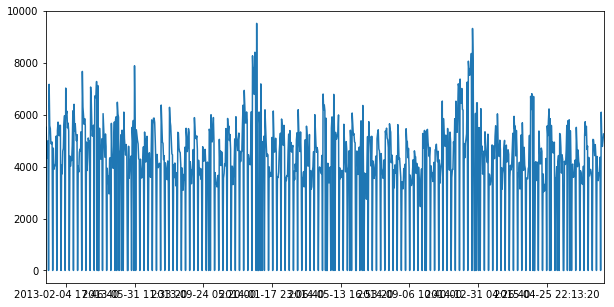

In [58]:
store = 1

import matplotlib.dates as mdates
import matplotlib as mpl

def datetimeformatter(x, pos):
    return pd.to_datetime(x)

df_ts = df_train.copy()
df_ts.sort_values('Date')
date = pd.to_datetime(df_ts[df_ts['Store'] == store].Date).values.astype('datetime64[D]')
sales = df_ts[df_ts['Store'] == store].Sales
fig, axes = plt.subplots(figsize=(10,5))
sns.tsplot(sales, date, ax = axes)
axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(datetimeformatter))
plt.show()

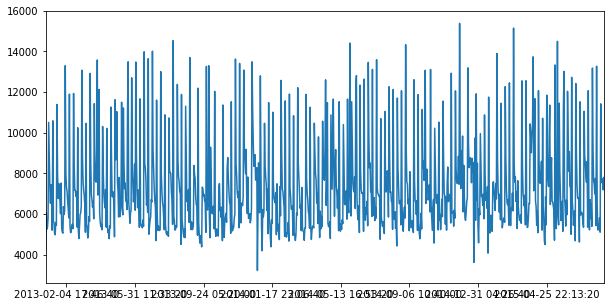

In [59]:
store = 85

import matplotlib.dates as mdates
import matplotlib as mpl

def datetimeformatter(x, pos):
    return pd.to_datetime(x)

df_ts = df_train.copy()
df_ts.sort_values('Date')
date = pd.to_datetime(df_ts[df_ts['Store'] == store].Date).values.astype('datetime64[D]')
sales = df_ts[df_ts['Store'] == store].Sales
fig, axes = plt.subplots(figsize=(10,5))
sns.tsplot(sales, date, ax = axes)
axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(datetimeformatter))
plt.show()

The reason for this observation is because Some stores is not open on Sunday. This is an excellent feature that we can include in our training data as we can immediately predict that the sales is zero if the particular store is not open on Sunday!

In [60]:
store = 1
df_indiv_store = df_train[df_train['Store'] == store]
df_indiv_store.groupby('DayOfWeek').Open.sum()

DayOfWeek
1    128
2    134
3    132
4    124
5    129
6    134
7      0
Name: Open, dtype: int64

In [61]:
store = 85
df_indiv_store = df_train[df_train['Store'] == store]
df_indiv_store.groupby('DayOfWeek').Open.sum()

DayOfWeek
1    134
2    135
3    135
4    135
5    135
6    134
7    134
Name: Open, dtype: int64

the `CompetitionOpenSinceYear` column looks fishy as the minimum value is 1900. I'm suspicious that it is an outlier value. To simplify the features and removing the excessive number of dummy variables, we will concatenate all stores that are open before year 2000. It does not make sense to retain the class as some Year have too few observations.

In [18]:
df_stores.groupby('CompetitionOpenSinceYear').size()

CompetitionOpenSinceYear
1900.0     1
1961.0     1
1990.0     5
1994.0     2
1995.0     2
1998.0     1
1999.0     8
2000.0    10
2001.0    16
2002.0    27
2003.0    19
2004.0    22
2005.0    62
2006.0    47
2007.0    48
2008.0    54
2009.0    54
2010.0    55
2011.0    54
2012.0    82
2013.0    83
2014.0    70
2015.0    38
dtype: int64

## Feature Engineering

As we would like to perform feature engineering, we will concat the train and test dataset temporarily. This allows us to create features for both datasets at one go. Furthermore, later we will extract features based on the store Id across all test and train observations. 

In performing this concat, we need to create dummy column for train `Id`, test `Sales`, and test `Customers`. We will also create `TrainTest` column to identify whether the observation come from a `Train` dataset or `Test` Dataset. 

In [11]:
def create_df_merge(train_df, test_df):
    df_train = train_df.copy()
    df_test = test_df.copy()
    df_train['Id'] = df_train.index
    df_test['Sales'] = 0.
    df_test['Customers'] = 0.
    df_train['TrainTest'] = 'Train'
    df_test['TrainTest'] = 'Test'
    df_train = df_train[sorted(df_train.columns)]
    df_test = df_test[sorted(df_test.columns)]
    assert df_train.columns.tolist() == df_test.columns.tolist()
    df_merge = pd.concat([df_train, df_test])
    return df_merge

The first Feature engineering is to create basic features, which is defined as features that are engineered from other columns within that observations. We will also transform some numerical features which should have been a categorical features into string, so that we are able to perform one-hot encoding using `pd.get_dummmies()` later. The features that we have engineered in the `create_basic_features` are:

- `Year` - Year of the observation. Derived from `Date`
- `Month` - Month of the observation. Derived from `Date`
- `Week` - Week of the observation. Derived from `Date`
- `Day` - Day of the observation. Derived from `Date`
- Simplifying `StateHoliday` - Only stating whether today is a holiday or not
- Filling up `CompetitionDistance` missing values with the mean between all `CompetitionDistance`
- Removing outliers on `CompetitionOpenSinceYear`. All observations before year 2000 is converted into year 2000.
- Filling up `CompetitionOpenSinceMonth` missing values with January
- Forcing `CompetitionDistance` values to be zero if the Competition store has not been open during the date of the observation. This steps makes sense because that means there are currently no competition around the drug store.
- Create column `CompetitionDaysElapsed` which tracks how many days the competitior stores has been opened at the time of the observation.
- Create column `Promo2DaysSinceElapsed` which tracks how many days the store have joined the `Promo2` sales at the time of the observation.


In [12]:
def create_basic_features(df):
    df.Date = pd.to_datetime(df.Date)
    df["Store"] = df["Store"].astype(str)
    df["DayOfWeek"] = df["DayOfWeek"].astype(str)
    df["Year"] = df.Date.dt.year.astype(str)
    df["Month"] = df.Date.dt.month.astype(str)
    df["Week"] = df.Date.dt.week.astype(str)
    df["Day"] = df.Date.dt.day.astype(str)
    df['StateHoliday'] = df['StateHoliday'] != '0'
    df['SchoolHoliday'] = df['SchoolHoliday'] != 0
    df['Open'] = df['Open'] != 0
    df['Promo'] = df['Promo'] != 0
    df['CompetitionDistance'] = df['CompetitionDistance'].\
    fillna(df['CompetitionDistance'].mean())
    df.loc[df['CompetitionOpenSinceYear'] < 2000, 
           'CompetitionOpenSinceYear'] = 2000
    df['CompetitionOpenSinceYear'] =\
    df['CompetitionOpenSinceYear'].fillna(2000).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = \
    df['CompetitionOpenSinceMonth'].fillna(1).astype(np.int32)
    df["CompetitionOpenSinceDateTime"] = \
    pd.to_datetime(df.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 1)
                            , axis=1).astype(pd.datetime))
    df["CompetitionDaysElapsed"] = \
    df.Date.subtract(df["CompetitionOpenSinceDateTime"]).dt.days
    competition_distance = df['CompetitionDistance'].values
    competition_elapsed = df['CompetitionDaysElapsed'].values
    df['CompetitionDistance'] = np.where(competition_elapsed>= 0.,
                                         competition_distance, 0.)
    df['CompetitionDaysElapsed'] = np.where(competition_elapsed >= 0.,
                                            competition_elapsed, 0.)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(2009).astype(np.int32)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(1).astype(np.int32)
    df["Promo2SinceDateTime"] = pd.to_datetime(df.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2SinceDaysElapsed"] = df.Date.subtract(df["Promo2SinceDateTime"]).dt.days
    return df

We will also try to create `advanced_features` which is dependent on the `Store` ID of the observation. The features that we want to create for each store are
- `sales_mean` - the mean of the sales for a particular store over train period
- `customer_mean` - the mean of the customer coming to the store in a day for a particular store over train period
- `is_open_sunday` - Whether the store is open on Sunday. After performing some observation, I identify that some of the stores are not open at all on sunday
- `state_hols_array` - The starting dates of all state holidays for the particular store over all train and test dataset
- `school_hols_array` - The starting dates for all school holidays for the particular store over all train and test dataset
- `promo_array` - The starting dates for all promos for the particular store over all train and test dataset

In [13]:
def create_store_dictionary(merge_df):
    df = merge_df.copy()
    df = df.sort_values(['Date'])
    dict_store = {}
    for store in tqdm(np.unique(df.Store)):
        df_store = df[df.Store == store]
        sales_mean = df.loc[(df.Sales > 0.0) \
                            & (df.Store == store),"Sales"].mean()
        customer_mean = df.loc[(df.Customers > 0.0) \
                               & (df.Store == store), "Customers"].mean()
        is_open_sunday = df.loc[(df.Sales > 0.0)\
                                & (df.DayOfWeek == 7)\
                                & (df.Store == store),"Customers"].empty
        state_hols_array = df_store.StateHoliday.values
        state_hols_starting_date = \
        df_store.Date[np.append([state_hols_array[0] == 1],
                                (state_hols_array[:-1] == 0) \
                                & (state_hols_array[1:] == 1))].values
        school_hols_array = df_store.SchoolHoliday.values
        school_hols_starting_date = \
        df_store.Date[np.append([school_hols_array[0] == 1], 
                                (school_hols_array[:-1] == 0) \
                                & (school_hols_array[1:] == 1))].values
        promo_array = df_store.Promo.values
        promo_starting_date = \
        df_store.Date[np.append([promo_array[0] == 1], 
                                (promo_array[:-1] == 0) & \
                                (promo_array[1:] == 1))].values
        dict_store[store] = {
            'sales_mean' : sales_mean,
            'customer_mean' : customer_mean,
            'is_open_sunday' : is_open_sunday,
            'state_hols_array' : state_hols_starting_date,
            'school_hols_array' : school_hols_starting_date,
            'promo_array' : promo_starting_date
        }
    return dict_store

- We will then create a function that is able to return the `sales_mean`, `customer_mean`, and `is_open_sunday` given an array of stores. 

- We will also engineer a feature that tracks the upcoming and previous holiday/promo. 

- `before_state_hols_date`, `before_school_hols_date`, and `before_promo_date` return the number of days remaining before the next State Holiday / School Holiday / Promo in that store 

- `after_state_hols_date`, `after_school_hols_date`, and `after_promo_date` returns the number of days that have elapsed since the last State Holiday / School Holiday / Promo that happens in that store.

In [14]:
def get_sales_mean(dict_store, array_store):
    array_sales_mean = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        array_sales_mean[idx] = \
        dict_store[array_store[idx]]['sales_mean']
    return array_sales_mean

def get_customer_mean(dict_store, array_store):
    customer_sales_mean = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        customer_sales_mean[idx] = \
        dict_store[array_store[idx]]['customer_mean']
    return customer_sales_mean

def get_is_open_sunday(dict_store, array_store):
    is_open_sunday_mean = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        is_open_sunday_mean[idx] = \
        dict_store[array_store[idx]]['is_open_sunday']
    return is_open_sunday_mean

def before_state_hols_date(dict_store, array_date, 
                           array_store, array_state_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_state_hols[idx] == True:
            result[idx] = 0
        else:
            store_array_date = \
            dict_store[array_store[idx]]\
            ['state_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            before_values = np.abs(value[np.where(value <= 0.0)])
            if len(before_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(before_values)
    return result

def after_state_hols_date(dict_store, array_date, array_store, array_state_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_state_hols[idx] == True:
            result[idx] = 0
        else:
            store_array_date = \
            dict_store[array_store[idx]]\
            ['state_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            after_values = value[np.where(value >= 0.0)]
            if len(after_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(after_values)
    return result

def before_school_hols_date(dict_store, array_date, array_store, array_school_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_school_hols[idx] == True:
            result[idx] = 0
        else:
            store_array_date = \
            dict_store[array_store[idx]]\
            ['school_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            before_values = np.abs(value[np.where(value <= 0.0)])
            if len(before_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(before_values)
    return result

def after_school_hols_date(dict_store, array_date, array_store, array_school_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_school_hols[idx] == True:
            result[idx] = 0 
        else:
            store_array_date = \
            dict_store[array_store[idx]]\
            ['school_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            after_values = value[np.where(value >= 0.0)]
            if len(after_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(after_values)
    return result

def before_promo_date(dict_store, array_date, array_store, array_promo):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_promo[idx] == True:
            result[idx] = 0
        else:
            store_array_date =\
            dict_store[array_store[idx]]\
            ['promo_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            before_values = np.abs(value[np.where(value <= 0.0)])
            if len(before_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(before_values)
    return result

def after_promo_date(dict_store, array_date, array_store, array_promo):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_promo[idx] == True:
            result[idx] = 0
        else:
            store_array_date = \
            dict_store[array_store[idx]]\
            ['promo_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            after_values = value[np.where(value >= 0.0)]
            if len(after_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(after_values)
    return result

In [15]:
def create_advanced_features(df, dict_store):
    array_store = df['Store'].values
    array_date = df['Date'].values
    array_state_hols = df['StateHoliday'].values
    array_school_hols = df['SchoolHoliday'].values
    array_promo = df['Promo'].values
    df['sales_mean'] = get_sales_mean(dict_store, array_store)
    df['customer_mean'] = get_customer_mean(dict_store, array_store)
    df['is_open_sunday'] = get_is_open_sunday(dict_store, array_store)
    df['prev_StateHoliday'] = \
    before_state_hols_date(dict_store, array_date, 
                           array_store, array_state_hols)
    df['next_StateHoliday'] = \
    after_state_hols_date(dict_store, array_date,                          
                          array_store, array_state_hols)
    df['prev_SchoolHoliday'] = \
    before_school_hols_date(dict_store, array_date, 
                            array_store, array_school_hols)
    df['next_SchoolHoliday'] = \
    after_school_hols_date(dict_store, array_date,
                           array_store, array_school_hols)
    df['prev_Promo'] = \
    before_promo_date(dict_store, array_date,
                      array_store, array_promo)
    df['next_Promo'] = \
    after_promo_date(dict_store, array_date, 
                     array_store, array_promo)
    return df

After we finish with the feature engineering, we can then identify all the categorical features that we have in our dataset. We can then create dummy variables for each categorical features in our dataset. We will then split the train test set back, according to our `TrainTest` label. 

All the features that we would like to use to train the data is at `X_train`. `X_test` contains all the features of the test data. Lastly, `Y_train` contains the Sales value for our train dataset

In [16]:
def create_train_test_split(df, one_hot = True):
    all_features = ['DayOfWeek', 'Open',
                   u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'Year', u'Month', u'Week',
       u'Day', u'CompetitionDaysElapsed',
        u'Promo2SinceDaysElapsed', u'sales_mean',
       u'customer_mean', u'is_open_sunday', u'prev_StateHoliday',
       u'next_StateHoliday', u'prev_SchoolHoliday', u'next_SchoolHoliday',
       u'prev_Promo', u'next_Promo', 'TrainTest', 'Sales']
    cat_features = ['DayOfWeek', 'StoreType', 'Assortment', 
                    'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear',
                   'Promo2SinceWeek', 'Promo2SinceYear', 
                    'Year', 'Month', 'Week', 'Day']
    for x in cat_features:
        df[x] = df[x].astype(str)
    df = df[all_features]
    if one_hot:
        df = pd.get_dummies(df, prefix = cat_features, columns= cat_features)
    else:
        df = df
    df_train = df[df['TrainTest'] == 'Train']
    df_test  = df[df['TrainTest'] == 'Test']
    
    df_X_train =  df_train.drop(['TrainTest', 'Sales'], axis = 1)
    df_X_test = df_test.drop(['TrainTest', 'Sales'], axis = 1)
    
    assert df_X_train.columns.tolist() == df_X_test.columns.tolist()
    
    X_train = df_X_train.values
    X_test = df_X_test.values
    Y_train = df_train['Sales'].values
    
    return X_train, Y_train, X_test, df_X_train.columns

We concatenate all the feature engineering/data cleansing procedure to the train/test dataset in this `run_processing_pipeline` feature

In [17]:
def run_preprocessing_pipeline(df_train, df_test, one_hot = True):
    df_merge = create_df_merge(df_train, df_test)
    df_merge_basic_feat = create_basic_features(df_merge)
    dict_store = create_store_dictionary(df_merge)
    df_merge_adv_feat = create_advanced_features(df_merge, df_store)
    X_train, Y_train, X_test, column_names = \
    create_train_test_split(df_features, one_hot)
    return  X_train, Y_train, X_test, column_names

In [18]:
df_merge = create_df_merge(df_train, df_test)

In [18]:
df_merge_basic_feat = create_basic_features(df_merge)

In [57]:
dict_store = create_store_dictionary(df_merge)

In [69]:
df_merge_adv_feat = create_advanced_features(df_merge, dict_store)

In [ ]:
X_train, Y_train, X_test, column_names = \
create_train_test_split(df_merge_adv_feat, one_hot = True)

Sanity Check to ensure that the number of observations does not decreases after the feature engineering as I do not perform any outlier removal in this dataset

In [31]:
print X_train.shape
print Y_train.shape
print X_test.shape

(1017209, 188)
(1017209,)
(41088, 188)


To allow easy exporting/importing of our training/test array, we store it in a `pickle` format

In [99]:
joblib.dump(df_merge_basic_feat, 'df_merge_basic_feat.pkl') 
joblib.dump(dict_store, 'dict_store.pkl') 
joblib.dump(df_merge_adv_feat, 'df_merge_adv_feat.pkl') 
joblib.dump(X_train, 'X_train.pkl') 
joblib.dump(Y_train, 'Y_train.pkl') 
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(column_names, 'column_names.pkl')

['column_names.pkl']

In [4]:
df_merge_basic_feat = joblib.load('df_merge_basic_feat.pkl')
dict_store = joblib.load('dict_store.pkl')
df_merge_adv_feat = joblib.load('df_merge_adv_feat.pkl')
X_full_train = joblib.load('X_train.pkl')
Y_full_train = joblib.load('Y_train.pkl')
X_test = joblib.load('X_test.pkl')
column_names = joblib.load('column_names.pkl')

For the validation, we will use simple train-test split function provided from the `sklearn` package. We will set aside 20% of our data to evaluate the performance of our various models used in predicting the Sales of the Rossmann stores. `X_val` and `Y_val` indicates the features and the ground truth Sales of our observations from the train dataset which is excluded from the training process

In [5]:
X_train, X_val, Y_train, Y_val = \
train_test_split(X_full_train, Y_full_train, 
                 test_size = 0.20, random_state = 1234)

Last Sanity Check to ensure that there are no suspicious values in the dataset after performing feature engineering / data cleansing. I have also ensured that there are no more missing values in all features that I will use in training the model. It should be noted that I will not use `PromoInterval` as part of the prediction in this model

In [6]:
DataFrameSummary(df_merge_adv_feat).summary()

,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Id,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday,Store,StoreType,TrainTest,Year,Month,Week,Day,CompetitionOpenSinceDateTime,CompetitionDaysElapsed,Promo2SinceDateTime,Promo2SinceDaysElapsed,sales_mean,customer_mean,is_open_sunday,prev_StateHoliday,next_StateHoliday,prev_SchoolHoliday,next_SchoolHoliday,prev_Promo,next_Promo
count,NaN,1.0583e+06,NaN,NaN,1.0583e+06,NaN,NaN,1.0583e+06,NaN,NaN,1.0583e+06,NaN,NaN,NaN,1.0583e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0583e+06,NaN,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06
mean,NaN,4977.7,NaN,NaN,608.564,NaN,NaN,489655,NaN,NaN,0.503671,NaN,NaN,NaN,5549.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2902.97,NaN,1361.48,6940.16,757.689,1,30.6031,24.3145,26.1157,22.7906,5.65169,3.10491
std,NaN,7516.57,NaN,NaN,471.449,NaN,NaN,302941,NaN,NaN,0.499987,NaN,NaN,NaN,3935.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.87,NaN,773.68,2387,355.863,0,31.0979,29.8057,23.55,23.0989,6.83561,3.32256
min,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-881,2703.74,240.183,1,0,0,0,0,0,0
25%,NaN,450,NaN,NaN,363,NaN,NaN,223486,NaN,NaN,0,NaN,NaN,NaN,3319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,928,NaN,775,5321.14,543.676,1,4,1,6,2,0,0
50%,NaN,2060,NaN,NaN,594,NaN,NaN,488060,NaN,NaN,1,NaN,NaN,NaN,5600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2810,NaN,1576,6607.94,681.15,1,20,12,22,18,6,2
75%,NaN,6250,NaN,NaN,824,NaN,NaN,752634,NaN,NaN,1,NaN,NaN,NaN,7749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5004,NaN,1972,7967.27,867.466,1,52,38,41,37,10,6
max,NaN,75860,NaN,NaN,7388,NaN,NaN,1.01721e+06,NaN,NaN,1,NaN,NaN,NaN,41551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5738,NaN,2453,21757.5,3403.46,1,135,195,118,194,188,16
counts,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,533034,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297
uniques,3,655,12,16,4086,990,7,1017209,2,2,2,24,7,3,21734,2,2,1115,4,2,3,12,52,31,162,5739,56,3335,1115,1114,1,136,147,119,118,21,17


## Model

It should be noted that the submissions in the Kaggle competitions are evaluated using RMSPE ( Root Mean Square Percentage Error ) . As I am mostly using `sklearn` and `xgboost` package in my model building, and the evaluation method is not supported by both packages, I will need to create the function itself from scratch using sklearn's `make_scorer` function.

In [7]:
from sklearn.metrics import make_scorer

def rmpse_loss_func(ground_truth, predictions):
    idx = np.where(ground_truth > 0.)
    ground_truth = ground_truth[idx]
    predictions = predictions[idx]
    err = np.sqrt(np.mean((np.true_divide(predictions, ground_truth) - 1.)**2))
    return err

rmpse_loss  = make_scorer(rmpse_loss_func, greater_is_better=False)

There are few models that I will use in predicting the sales

- Linear regression
- Neural Network
- XGBoost with SKlearn wrapper
- Native XGBoost 
- Random Forest

I love tree ensemble method as they are more robust than linear models. As we do not perform any check on the distribution of values for each features in our training dataset, I hypothesize that the performance of all the tree ensembles will not be significantly impacted. Also, in this assignment I would like to try both XGBoost with the SKLearn wrapper as well as their native implementation as I want to try how does the XGBoost with SKlearn wrapper perform in conjunction with the hyperparameter tuning function `RandomizedSearchCV` provided under `sklearn` package

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.models import Model
from keras import backend as K
from xgboost import XGBRegressor

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Linear Regression

The Linear Regression Model is set up as a baseline for all of the other model.

In [9]:
linear_model = LinearRegression().fit(X_train, Y_train)

# NN 

I am also trying to use Deep Neural Network as one of the predictive model. The Deep Neural Network contain 5 hidden layers with 2048, 1024, 512, 256, and 128 Nodes respectively. I will perform batch normalization after the activation function in each layer and then perform Dropout with decreasing rates to reduce the chance of overfitting.

In [278]:
NN_idx = np.where(Y_train != 0.)
X_train_NN = X_train[NN_idx]
Y_train_NN = Y_train[NN_idx]

In [279]:
def rmspe_NN(y_true, y_pred):
    err = K.sqrt(K.mean(((y_pred / y_true) - 1.)**2))
    return err

In [286]:
inputs = Input(shape = (X_train_NN.shape[1],), name='Input')
X = Dense(2048, name='Dense1', activation='relu')(inputs)
X = BatchNormalization(name='BN1')(X)
X = Dropout(rate= 0.25)(X)
X = Dense(1024, name='Dense2', activation='relu')(X)
X = BatchNormalization(name='BN2')(X)
X = Dropout(rate= 0.20)(X)
X = Dense(512, name='Dense3', activation='relu')(X)
X = BatchNormalization(name='BN3')(X)
X = Dropout(rate= 0.15)(X)
X = Dense(256, name='Dense4', activation='relu')(X)
X = BatchNormalization(name='BN4')(X)
X = Dropout(rate= 0.10)(X)
X = Dense(128, name='Dense5', activation='relu')(X)
X = BatchNormalization(name='BN5')(X)
X = Dropout(rate= 0.05)(X)
outputs = Dense(1, name='Dense6', activation='relu')(X)

In [287]:
NN_model = Model(inputs=inputs, outputs=outputs, name='NN_Model')
NN_model.compile('adam', 'mean_squared_error' , metrics=[rmspe_NN])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 188)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 2048)              387072    
_________________________________________________________________
BN1 (BatchNormalization)     (None, 2048)              8192      
_________________________________________________________________
dropout_31 (Dropout)         (None, 2048)              0         
_________________________________________________________________
Dense2 (Dense)               (None, 1024)              2098176   
_________________________________________________________________
BN2 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
dropout_32 (Dropout)         (None, 1024)              0         
__________

In [289]:
NN_model.fit(X_train_NN, Y_train_NN, epochs=5, batch_size=64)

Epoch 1/3
675490/675490 [==============================] - 534s 791us/step - loss: 2347962.6519 - rmspe_NN: 0.2605
Epoch 2/3
675490/675490 [==============================] - 530s 785us/step - loss: 2210722.0510 - rmspe_NN: 0.2567
Epoch 3/3
675490/675490 [==============================] - 531s 785us/step - loss: 2155088.0333 - rmspe_NN: 0.2547


In [ ]:
NN_model.save('NN_model.h5')

In [10]:
NN_model = load_model('NN_model.h5')

## Xgboost - SKLearn Wrapper 

Using XGBoost - SKLearn Wrapper, we will perform Random Search Cross Validation from `sklearn` package. However, in performing this Random Search, there are a few mistakes that I have made.
- I do not create costum scorer function in evaluating the Cross Validation
- As I decrease the learning_rate, (default = 0.3), I do not increase the number of estimator as I thought my computer will take too long in performing the Random Search. This prevents the XGB model to truly converge

In [58]:
xgb_model = XGBRegressor(objective = 'reg:linear',
                         booster = 'gbtree', eta = 0.02, max_depth = 12, 
                         subsample = 0.9, 
                         colsample_bytree = 0.7, silent = False, n_jobs = 8)

In [ ]:
xgb_model.fit(X_train, Y_train)

In [42]:
xgb_params = {
    'learning_rate' : np.arange(0.01, 0.21, 0.01),
    'max_depth' : np.arange(3, 25, 1),
    'gamma' : np.arange(0., 3., 1.),
    'min_child_weight' : np.arange(0., 6., 1.),
    'colsample_bytree' : np.arange(0., 1.01, 0.1)
}

In [ ]:
start = time.time()
xgb_CV_model = RandomizedSearchCV(estimator=xgb_model,
                                  param_distributions=xgb_params,
                                  n_iter= 60, 
                                  scoring='neg_mean_squared_error',
                                  cv=3, verbose=4, n_jobs = 1,  
                                  return_train_score = True).fit(X_train, Y_train)
end = time.time()
end - start

In [ ]:
joblib.save(xgb_CV_model, "xgb_CV_model.pkl")

In [11]:
xgb_CV_model = joblib.load("xgb_CV_model.pkl")

As we can see from the result of the cross validation, the models that are too deep will most likely overfit and the models that are not deep enough / having High Gamma value will suffer from high bias. 

In [72]:
pd.DataFrame(xgb_CV_model.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
46,184.288273,2.526122,-927060.622836,-371174.039759,0.9,0,0.13,11,3,"{u'learning_rate': 0.13, u'colsample_bytree': ...",1,-869841.066912,-380193.137466,-9.963863e+05,-364101.832192,-914954.492780,-369227.149620,4.748510,0.021664,52366.304072,6711.945186
12,163.215883,2.371760,-935827.039576,-389499.528863,0.9,0,0.18,10,4,"{u'learning_rate': 0.18000000000000002, u'cols...",2,-874453.903523,-403468.750787,-1.006261e+06,-372770.419201,-926766.392915,-392259.416600,0.302082,0.023468,54190.034595,12683.575357
10,205.320029,3.233024,-941299.201061,-285847.730092,0.9,2,0.14,12,1,"{u'learning_rate': 0.14, u'colsample_bytree': ...",3,-894346.884255,-300958.236839,-9.844615e+05,-276405.008990,-945089.194348,-280179.944448,0.748779,0.205565,36886.651648,10795.310557
4,297.192521,3.620282,-952611.070160,-174858.634522,1,1,0.12,15,3,"{u'learning_rate': 0.12, u'colsample_bytree': ...",4,-898400.584332,-177327.831553,-1.027848e+06,-174808.696339,-931584.298866,-172439.375673,0.293465,0.235779,54898.527597,1996.016131
55,368.009470,4.381860,-954167.844287,-175851.201776,0.9,0,0.1,16,5,"{u'learning_rate': 0.09999999999999999, u'cols...",5,-914102.797125,-182322.811121,-1.007889e+06,-173062.088544,-940511.849471,-172168.705663,1.510716,0.199279,39486.893485,4590.630231


## Native SKlearn

I will also use Native SKlearn to predict the model. The value of the parameters is inspired from the kernel https://www.kaggle.com/abhilashawasthi/xgb-rossmann. I will also need to define rmpse which I can use to monitor the performance of our model as I fit the xgb model

In [19]:
dtrain = xgb.DMatrix(X_train, label= Y_train)

In [20]:
dtest = xgb.DMatrix(X_val, label=Y_val)

In [317]:
def rmpse(preds, dtrain):
    labels = dtrain.get_label()
    idx = np.where(labels > 0.)
    labels = labels[idx]
    preds = preds[idx]
    err = np.sqrt(np.mean((np.true_divide(preds, labels) - 1.)**2))
    return 'error', err

In [318]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]

In [319]:
param = { 'objective' : "reg:linear", 
          'booster' : "gbtree",
          'eta'                 :0.05, 
          'max_depth'           :9, 
          'subsample'           : 0.9,
          'colsample_bytree'    : 0.7,
          'n_thread' : 8
        }

In [12]:
bst = xgb.Booster()
bst.load_model('bst.model')

In [ ]:
bst = xgb.train(param, dtrain, evals=watchlist, 
                num_boost_round = 2000, feval= rmpse, maximize = False)

In [321]:
bst.save_model('bst.model')

## Random Forest

Lastly, I will define the Random Forest model. I will use default setting provided from the `sklearn` package except I will increase the depth of the trees as I believe that the observations is large enough so that I won't suffer from overfitting. Furthermore, I will also slightly increase the number of trees in the forest

In [1]:
rf_model = RandomForestRegressor(n_estimators = 500, 
                                 max_features = 'sqrt', n_jobs = -1 , verbose = 3)\
.fit(X_train, Y_train)

NameError: name 'RandomForestRegressor' is not defined

In [14]:
joblib.dump(rf_model, 'rf_CV_model.pkl')

['rf_CV_model.pkl']

## Scoring

Using the self-defined RMPSE loss function, I evaluate the performance of each model. Surprisingly, the result for both NN model is much worse than the linear model. One reason is that we have not been able to find the suitable architecture which is able to predict the Sales value. It might be because we do not train them with enough epoch, therefore the performance is even worse than a Linear Model.

In [26]:
print rmpse_loss(linear_model, X_train, Y_train)
print rmpse_loss(linear_model, X_val, Y_val)

-0.3179728070670008
-0.293745468990658


In [16]:
NN_train = NN_model.predict(X_train).reshape(-1)
NN_test = NN_model.predict(X_val).reshape(-1)
print - rmpse_loss_func(Y_train, NN_train)
print - rmpse_loss_func(Y_val, NN_test)

-0.48653256762244584
-0.46219829480028884


In [17]:
print rmpse_loss(xgb_CV_model, X_train, Y_train)
print rmpse_loss(xgb_CV_model, X_val, Y_val)

-0.1759966843792945
-0.1384333502214052


In [24]:
bst_train = rmpse_loss_func(Y_train,bst.predict(dtrain))
print -bst_train
bst_val = rmpse_loss_func(Y_val,bst.predict(dtest))
print -bst_val

-0.12439903027006809
-0.12082965264811764


In [25]:
print rmpse_loss(rf_model, X_train, Y_train)
print rmpse_loss(rf_model, X_val, Y_val)

-0.0714674720014398
-0.1480786655463947


## Prediction

In [329]:
new_X_test = X_test[df_test.sort_values(['Id']).index]
dsubmit = xgb.DMatrix(new_X_test)
sales_value =  bst.predict(dsubmit)

In [332]:
result = {
    'Id': df_test.sort_values(['Id']).Id.values,
    'Sales':  sales_value
}

df_result = pd.DataFrame(result)

In [333]:
df_result.to_csv('entry.csv', index=False)